## Using YOLOv5 pretrained for detection American Sign letter language

- ASL possesses a set of 26 signs known as the American manual alphabet, which can be used to spell out words from the English language. Such signs make use of the 19 handshapes of ASL. For example, the signs for 'p' and 'k' use the same handshape but different orientations. A common misconception is that ASL consists only of fingerspelling; although such a method (Rochester Method) has been used, it is not ASL.

- Fingerspelling is a form of borrowing, a linguistic process wherein words from one language are incorporated into another. In ASL, fingerspelling is used for proper nouns and for technical terms with no native ASL equivalent. There are also some other loan words which are fingerspelled, either very short English words or abbreviations of longer English words, e.g. O-N from English 'on', and A-P-T from English 'apartment'. Fingerspelling may also be used to emphasize a word that would normally be signed otherwise.

In [ ]:
%pip install -U -q PyDrive

### Mounting Google Drive

In [2]:
#conrct to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load data

In [3]:
dataset_path = "/content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch"


### clone to github/yolov5

In [ ]:
## clone to github/yolov5
%git clone https://github.com/ultralytics/yolov5
%pip install -qr yolov5/requirements.txt
%cd yolov5
#Import libraris
import torch
from IPython.display import Image, clear_output
import os
import shutil
clear_output()

In [5]:
import shutil
shutil.copy('/content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/data.yaml',
            '/content/yolov5/data/data.yaml')


'/content/yolov5/data/data.yaml'

In [6]:
#extracting information from the roboflow file
%cat /content/yolov5/data/data.yaml

train: ../train/images
val: ../valid/images

nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [7]:
# define number of classes based on data.yaml
import yaml
with open("/content/yolov5/data/data.yaml", 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])


# Yolov5m

In [8]:
%cat /content/yolov5/models/yolov5m.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml
# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
yaml_text = """
train: /content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/train/images
val: /content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/valid/images

nc: 26
names: [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
         'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z' ]
"""

with open('/content/yolov5/data/data.yaml', 'w') as f:
    f.write(yaml_text)


In [12]:
# Train YOLOv5m on custom ASL dataset for 150 epochs
# Measure training time
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 50 \
    --data './data/data.yaml' \
    --cfg ./models/custom_yolov5m.yaml \
    --weights '' \
    --name yolov5m_results \
    --cache


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
       3/49      6.23G    0.07135    0.02457    0.08067         76        416:  15% 7/48 [00:02<00:15,  2.72it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       3/49      6.23G    0.07129    0.02488    0.08057         77        416:  17% 8/48 [00:02<00:15,  2.63it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       3/49      6.23G    0.07067    0.02461     0.0805         61        416:  19% 9/48 [00:03<00:15,  2.58it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
   

In [ ]:
%python detect.py --weights runs/train/yolov5m_results/weights/best.pt \
                  --img 416 \
                  --conf 0.4 \
                  --source /content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/test/images


detect: weights=['runs/train/yolov5m_results/weights/best.pt'], source=/content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20953959 parameters, 0 gradients, 48.2 GFLOPs
image 1/72 /content/gdrive/MyDrive/American_Sign_Language_Letters.v1-v1.yolov5pytorch/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 416x416 1 A, 15.9ms
image 2/72 /content/gdrive/MyDrive/American_Sign_Language_L

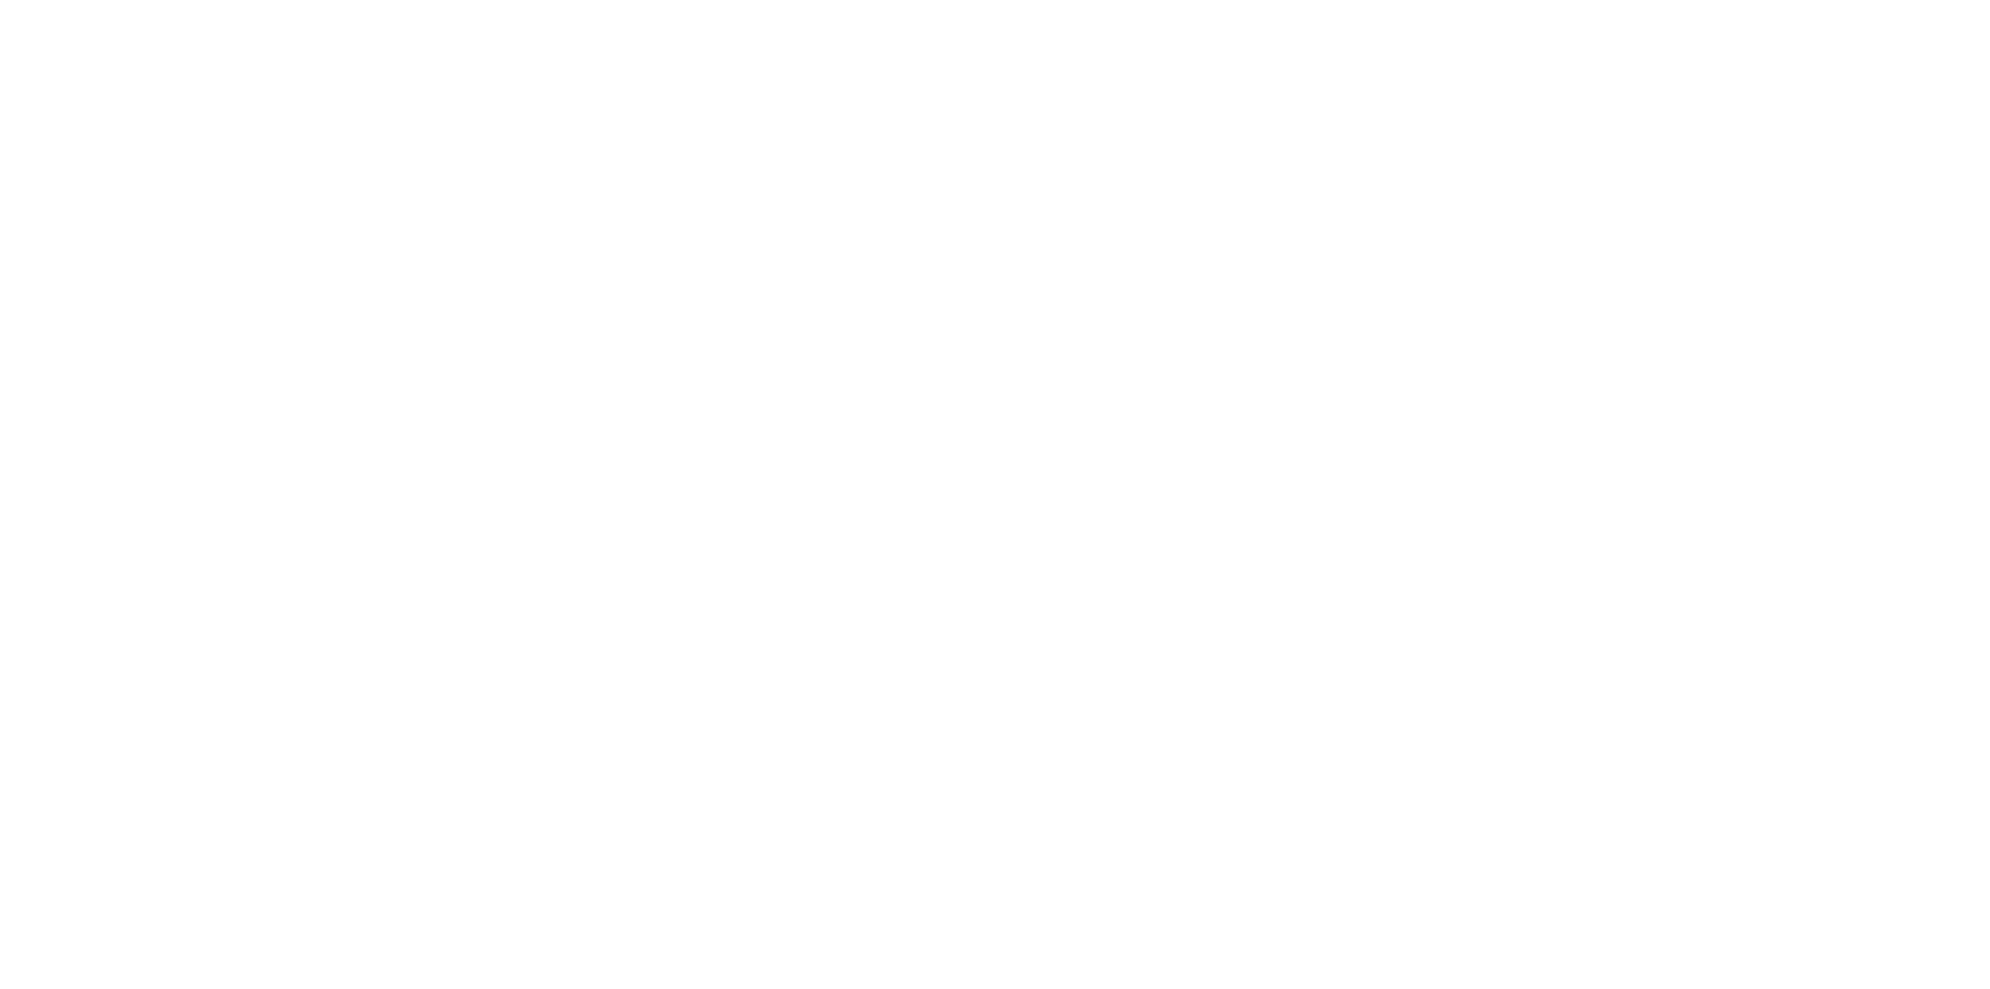

In [14]:
import glob
import matplotlib.pyplot as plt

# Collect detected image paths
image_paths = sorted(glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'))

# Limit to 10 images
image_paths = image_paths[:10]

# Setup plot grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axs = axs.flatten()

for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'Detection {i+1}')

# Hide unused subplots
for j in range(len(image_paths), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
